<a href="https://colab.research.google.com/github/Ricardojnf33/sistema_de_recomendacao/blob/main/product_recommendation_apriori_causal_mlV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎖Product Recommendation - Apriori & causal ML - Link:
https://www.kaggle.com/code/hunter0007/product-recommendation-apriori-causal-ml

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## ENTENDIMENTO DE NEGÓCIOS

Hunter's e-grocery é uma conhecida marca francesa com sede na Bretanha que oferece uma nova geração de produtos de e-mercearia e estilo de vida. Com presença em dez países, o e-grocery da Hunter busca continuamente novas maneiras de antecipar e atender às demandas dos clientes, construindo uma forte lealdade entre seus clientes. No entanto, eventos recentes de cisnes negros, como o Covid-19, a crise na Ucrânia e a escassez de gás, impactaram o comportamento de compra, tornando necessário desenvolver uma proposta de valores de negócios para aumentar o valor da vida útil do cliente. Para garantir a conclusão bem-sucedida deste extenso estudo, implementaremos uma metodologia de 5 etapas.

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#be6f37;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">ÍNDICE</p>

[VISÃO GERAL](#0)
- [1. COMPREENDENDO O NEGÓCIO](#1)

- [2. COMPREENDENDO OS DADOS](#2)

    - [2.1 Obter informações sobre os dados](#2.1)
    - [2.2 Realizando estatísticas resumidas](#2.2)
    - [2.3 Lidando com valores nulos](#2.3)
    - [2.4 Convertendo tipos de dados](#2.4)
- [3. PREPARAÇÃO DOS DADOS](#3)
    - [3.1 Investigando todos os elementos de cada atributo](#3.1)
    - [3.2 Agregando e agrupando valores para visualizar o comportamento de compra](#3.2)
    - [3.3 Criando atributos baseados no tempo](#3.3)
    - [3.4 Estudo de heatmap](#3.4)
    - [3.5 Visualizando o período de tempo do pedido](#3.5)
    - [3.6 Criando atributo de grupo de pedido](#3.6)
    - [3.7 Visualizando o atributo de grupo de pedido](#3.7)
    - [3.8 Visualizando os 10 principais produtos](#3.8)
    - [3.9 Visualizando os 10 produtos com menor quantidade](#3.9)
    - [3.9 Agregando e agrupando valores para entender o comportamento de compra](#3.10)
    - [3.10 Agregando e agrupando valores para entender a taxa de reincidência do produto](#3.11)
    - [3.11 Agregando e agrupando valores para visualizar a taxa de reincidência](#3.12)

- [4. MODELAGEM](#4)

    - [4.1 Preparando e construindo o algoritmo apriori](#4.1)
    - [4.2 Construindo parâmetros personalizados para o gráfico](#4.2)
    - [4.3 BConstruindo os itens de ocorrência frequente](#4.3)
    - [4.4 Adicionando contagem de conjuntos de itens à lista de itens frequentes](#4.4)

- [5. IMPLANTAÇÃO](#5)
    - [5.1 Modelos de Inferência Causal e Estratégia de Relacionamentos](#5.1)
- [6. CONCLUSÃO](#6)

In [2]:
# IMPORTING PACKAGES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sns
from datetime import datetime
import sklearn
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans , k_means
from IPython.display import Image, display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_data= pd.read_csv("/content/ECommerce_consumer behaviour.csv")
df = main_data.copy()
df

<a id="2"></a>  
<p style="background-color:#be6f37;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;"> ENTENDIMENTO DOS DADOS</p>

#### **Os dados consistem em 2019501 linhas e 12 colunas, que são as seguintes:
**

- order_id – (Um número único para identificar o pedido)
- user_id - (Um número único para identificar o usuário)
- order_number – (Número do pedido)
- order_dow – (Dia da semana em que o pedido foi feito)
- order_hour_of_day – (Hora do pedido)
- days_since_prior_order - (Histórico do pedido)
- product_id – (ID do produto)
- add_to_cart_order – (Número de itens adicionados ao carrinho)
- reordered – (Se houve reincidência do pedido)
- department_id - (Número único atribuído a cada departamento)
- department – (Nomes dos departamentos)
- product_name – (Nome dos produtos)

<a id="2.1"></a>
## <b>2.1<span style='color:#be6f37'> Obtenha informações sobre os dados</span></b>

In [ ]:
df.info()

<a id="2.2"></a>
## <b>2.2 <span style='color:#be6f37'> Realização de estatísticas resumidas</span></b>

In [ ]:
df.isnull().sum()

#### <b><span style='color:#FF0000'> NOTA :</span></b>

**Nas estatísticas resumidas acima, pudemos ver que temos um valor nulo em "dayssince_prior_order", que é 6,8% de todo o conjunto de dados. A seguir estão as etapas que faremos para continuar na análise explicativa em ordem sequencial.**

In [ ]:
df['days_since_prior_order'].unique()

<a id="2.3"></a>
## <b>2.3 <span style='color:#be6f37'> Cuidando de valores nulos</span></b>

In [7]:
# TAKING CARE OF NULL VALUES
for col in df.columns:
    if df[col].dtypes == 'float64':
        df[col].fillna(-1,inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df.isnull().sum()

<a id="2.4"></a>
## <b>2.4 <span style='color:#be6f37'> Convertendo tipos de dados</span></b>

In [10]:
# CONVERTING DATA TYPES
df['days_since_prior_order']= df['days_since_prior_order'].astype(np.int64)

In [ ]:
df.info()

<a id="3"></a>
<p style="background-color:#be6f37;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;"> PREPARAÇÃO DOS DADOS</p>

<a id="3.1"></a>
## <b>3.1 <span style='color:#be6f37'> Investigando todos os elementos dentro de cada recurso</span></b>

In [ ]:
for colum in df:
    unique_values = np.unique(df[colum])
    nr_values = len(unique_values)
    if nr_values < 22:
        print("The number of unique values for features {} : {} --- {}".format(colum, nr_values,unique_values))
    else:
         print("The number of unique values for features {} : {}".format(colum, nr_values))

<a id="3.2"></a>
## <b>3.2 <span style='color:#be6f37'> Agregar e agrupar valores para visualizar o comportamento de compra</span></b>

In [ ]:
# AGGREGATING & GROUPING VALUES TO VISUALIZE PURCHASING BEHAVIOUR
grouped = df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('dark')
sns.set_palette("rocket_r")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x=grouped.index, y=grouped.values, ax=ax)
ax.grid(True, axis='y')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of unique orders', fontsize=15)
plt.xlabel('Number of products added to cart', fontsize=15)
plt.title('Purchasing Behavior by Number of Products Added to Cart', fontsize=18)
plt.xlim(0, 35)  # limit the X axis values to 35
plt.show()

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**A partir do gráfico acima, podemos entender o comportamento de compra dos clientes, onde pudemos observar que os clientes geralmente pedem em média cerca de 4 a 7 produtos.**

<a id="3.3"></a>
## <b>3.3 <span style='color:#be6f37'> Criando recursos baseados em tempo</span></b>

In [ ]:
# TIME OF THE DAY WHEN THE ORDER WAS MADE
grouped = df.groupby('order_hour_of_day', as_index=True).agg({'user_id':'count'}).sort_values(by='user_id',ascending=False)


f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x = grouped.index, y = grouped.user_id)
sns.color_palette("rocket_r", 10)

plt.ylabel('Number of unique orders', fontsize=13)
plt.xlabel('Time of the day', fontsize=13)

for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+50, str(round(i.get_height())), fontsize=10, color='black')
plt.show()

plt.show()

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**No gráfico acima, podemos entender uma tendência em que a maioria dos clientes faz pedidos entre 10h e 16h**

<a id="3.4"></a>
## <b>3.4 <span style='color:#be6f37'> Estudo do Heatmap</span></b>

In [ ]:
day_hour_df = df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
day_hour_df_piv = day_hour_df.pivot('order_dow', 'order_hour_of_day', 'order_number')/df.shape[0]

plt.figure(figsize=(15,10))
sns.heatmap(day_hour_df_piv, cmap='YlGnBu')
plt.yticks([0,1, 2, 3, 4, 5, 6],["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Hour of day")
plt.yticks(rotation=0)
plt.ylabel("Day of week")


plt.title("Crosstable of days and hours of orders");

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**À medida que continuamos a explorar mais, podemos observar tendências interessantes que são as seguintes**
- **O pico de tráfego ocorre na segunda-feira, entre 10h e 16h, que é o início da semana**
- **Os períodos baixos acontecem no meio da semana, de quarta a sexta-feira, a partir das 16h**

In [16]:
def order_time(x):
    return f'{"morning" if x in range(6, 12) else "afternoon" if x in range(12, 18) else "evening" if x in range(18, 23) else "night"}'


In [ ]:
df['order_time_period'] = df['order_hour_of_day'].apply(order_time)
df

In [ ]:
df.pivot_table(index='order_dow',columns='order_time_period',values='user_id',aggfunc=['count'])

<a id="3.5"></a>
## <b>3.5 <span style='color:#be6f37'> Visualização do período de tempo do pedido</span></b>

In [ ]:
# Define the color palette
color_palette = plt.get_cmap('viridis')

# Generate the plot
orders_by_day_time = df.pivot_table(
    index='order_dow',
    columns='order_time_period',
    values='user_id',
    aggfunc='count'
)

ax = orders_by_day_time.plot(kind='bar', figsize=(15, 15), color=color_palette(np.linspace(0, 1, len(orders_by_day_time.columns))))
ax.set_title('The time when the order was made by day and time of day')
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]) # fixed the x-axis labels
ax.set_ylabel('Number of orders')
ax.legend(title='Orders Made', bbox_to_anchor=(1.0, 1.0))
plt.show()


#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**O gráfico acima novamente nos dá uma visão global onde podemos observar as tendências:**
- **Onde a maioria dos clientes prefere fazer o pedido entre a manhã e o início da tarde**
- **Poucos clientes relativamente tranquilos fazem pedidos durante a noite e a noite**

<a id="3.6"></a>
## <b>3.6 <span style='color:#be6f37'> Criação do recurso de grupo de pedidos</span></b>

In [20]:
def order_number_group(num_orders):
    ranges = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50),(51, 60),(61, 70),(71, 80),(81, 90),(91, 100)]
    for r in ranges:
        if num_orders in range(r[0], r[1]+1):
            return f"{r[0]}-{r[1]} orders"
    return "More than 100 orders"

In [ ]:
df['order_number_group']=df['order_number'].apply(order_number_group)
df

<a id="3.7"></a>
## <b>3.7 <span style='color:#be6f37'> Visualizando o recurso de grupo de pedidos</span></b>

In [ ]:
orders_by_group = df.groupby('order_number_group')['user_id'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('lightgray')

orders_by_group.plot(kind='pie', autopct='%1.2f%%', title='Number of Orders by Group', ax=ax)
ax.set_ylabel('')

plt.show()

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**O gráfico de pizza acima nos dá uma visão global da tendência de análise de cesta de mercado:**
- **De todos os produtos, aproximadamente 49% foram adquiridos do grupo categoria 1-10**

<a id="3.8"></a>
## <b>3.8 <span style='color:#be6f37'> Visualizando os 10 principais produtos</span></b>

In [ ]:
top_products = df.groupby('product_name')['user_id'].count().sort_values(ascending=False).head(10)
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', '#4E79A7', '#E69F00', '#F0E442', '#59A14F', '#8C8C8C', '#9C755F', '#EDB8A7', '#BDBDBD', '#000000']
ax = top_products.plot(kind='bar', title='Top 10 Products', color=colors, figsize=(15, 15))
plt.xlabel('Product Name',fontsize=13)
plt.ylabel('Number of Orders',fontsize=13)
for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+50, str(round(i.get_height())), fontsize=10, color='black')
plt.show()

<a id="3.9"></a>
## <b>3.9 <span style='color:#be6f37'> Visualizando os 10 últimos produtos</span></b>

In [ ]:
bottom_products = df.groupby('product_name')['user_id'].count().sort_values(ascending=False).tail(10)
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', '#4E79A7', '#E69F00', '#F0E442', '#59A14F', '#8C8C8C', '#9C755F', '#EDB8A7', '#BDBDBD', '#000000']
ax = bottom_products.plot(kind='bar', title='Bottom 10 Products', color=colors, figsize=(15, 15))
plt.xlabel('Product Name',fontsize=13)
plt.ylabel('Number of Orders',fontsize=13)
for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+50, str(round(i.get_height())), fontsize=10, color='black')
plt.show()

<a id="3.10"></a>
## <b>3.10 <span style='color:#be6f37'> Agregar e agrupar valores para entender o comportamento de compra</span></b>

In [ ]:
# AGGREGATING & GROUPING VALUES TO UNDERSTAND PURCHASING BEHAVIOUR
grouped = df.groupby(["product_id","product_name","department","order_time_period"])["reordered"].aggregate('count').reset_index()
grouped = grouped.sort_values(by='reordered', ascending=False)[:15].reset_index()
del grouped["index"]
grouped

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**Pela tabela acima podemos observar claramente que hortifrutigranjeiros, laticínios, bebidas e lanches são as categorias que mais interessam aos clientes.**

<a id="3.11"></a>
## <b>3.11 <span style='color:#be6f37'> Agregar e agrupar valores para entender a taxa de reordenamento do produto</span></b>

In [ ]:
# AGGREGATING & GROUPING VALUES TO UNDERSTAND PRODUCT REORDERED RATIO
grouped = df.groupby("reordered")["product_id"].aggregate('count').reset_index()
grouped['Ratio'] = grouped["product_id"].apply(lambda x: x /grouped['product_id'].sum())
grouped

<a id="3.12"></a>
## <b>3.12 <span style='color:#be6f37'> Agregando e agrupando valores para visualizar a proporção reordenada</span></b>

In [ ]:
grouped = grouped.groupby(['reordered']).sum()['product_id'].sort_values(ascending=True)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(x=grouped.index, y=grouped.values, palette='coolwarm')

grouped_pct = grouped/grouped.sum() * 100
for i, v in enumerate(grouped.values):
    ax.text(i, v+3, f'{grouped_pct.values[i]:.1f}%', ha='center', fontsize=10)

plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**Pelo exposto, podemos ver que 59% dos produtos foram reencomendados pelos clientes.**

<a id="4"></a>
<p style="background-color:#be6f37;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;"> MODELAGEM</p>

<a id="4.1"></a>
## <b> 4.1 <span style='color:#be6f37'> Apriori algoritmo </span></b>


O algoritmo Apriori é um algoritmo popular usado na mineração de dados para encontrar conjuntos de itens frequentes em um conjunto de dados. Ele funciona analisando o conjunto de dados para identificar itens de ocorrência comum e, em seguida, usa essas informações para gerar regras sobre quais itens tendem a aparecer juntos. O algoritmo tem duas etapas principais:

1. A primeira etapa envolve a identificação de todos os conjuntos de itens que atendem a um limite mínimo de suporte especificado (ou seja, o número mínimo de ocorrências necessárias para que um conjunto de itens seja considerado frequente). Isso é conhecido como a etapa de "geração frequente de conjunto de itens".
2. A segunda etapa envolve o uso dos conjuntos de itens frequentes gerados na etapa um para gerar regras de associação, que são regras que descrevem os relacionamentos entre diferentes itens no conjunto de dados. Essas regras podem ser usadas para prever quais itens provavelmente serão comprados juntos ou para identificar quais itens são comumente associados entre si.

**Além disso, o algoritmo Apriori é amplamente utilizado nas indústrias de varejo e comércio eletrônico para análise de cesta de compras, que envolve a análise dos padrões de compra do cliente para identificar quais itens são frequentemente comprados juntos.**



In [28]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
df

<a id="4.2"></a>
## <b> 4.2 <span style='color:#be6f37'> Construindo parâmetros de plotagem personalizados </span></b>

In [30]:
def bar_plot(df,col):

    fig = px.bar(df,
        x = df[col].value_counts().keys(),
        y = df[col].value_counts().values,
        color= df[col].value_counts().keys()
    )
    fig.update_layout(
    xaxis_title= col,
    yaxis_title="Count",
    legend_title=col,
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green"
)

    fig.show()

In [ ]:
# PRODUCT BAR PLOT
bar_plot(df, 'product_name')

In [ ]:
new_df = df.groupby(['user_id','department'])['product_name'].apply(sum)
new_df

In [33]:
transactions = [a[1]['product_name'].tolist() for a in list(df.groupby(['user_id','department']))]

In [ ]:
# DISPLAYING 20 PAIRS OF TRANSACTION
first_20_transactions = transactions[:20]

# PRINT HEAD OF 20 Print head of 20 transactions
for i, transaction in enumerate(first_20_transactions):
    print(f"Transaction {i+1}: {transaction}")

In [35]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

In [ ]:
# Get the head of 20 columns and create a list of dictionaries
head_cols = [{'Product': ' '.join(col)} for col in te.columns_[:20]]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(head_cols)

# Display the DataFrame
print(df)

In [ ]:
#te.columns_
te_ary

In [ ]:
transactions = pd.DataFrame(te_ary, columns=te.columns_)
pf = transactions.describe()
pf

In [ ]:
f = pf.iloc[0]-pf.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(50)
transactions

In [ ]:
item

In [ ]:
pio.renderers.default = "notebook_connected"
# TREEMAP VISUALIZATION OF ITEMS
fig = px.treemap(item, path=['Item'], values='Count')
fig.update_layout(title='Visualizing Item Counts with a Treemap', title_font_size=20, title_x=0.5)
fig.show()

<a id="4.3"></a>
## <b> 4.3 <span style='color:#be6f37'> Construindo os itens de ocorrência frequente </span></b>

In [ ]:
freq_items = apriori(transactions, min_support=0.005, use_colnames=True, verbose=1)
freq_items.head(7)

<a id="4.4"></a>
## <b> 4.4 <span style='color:#be6f37'> Adicionando contagem de conjuntos de itens à lista de itens frequentes </span></b>

In [ ]:
# ADDING ITEAMSETS COUNT TO THE FREQUENT ITEAM LIST
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

In [ ]:
freq_items.head(10)

In [ ]:
freq_items.tail(10)

### <b><span style='color:#FF0000'> DEMO</span></b>

In [ ]:
freq_items[(freq_items['length']==3)&(freq_items['support']>=0.005)]

#### <b><span style='color:#FF0000'> OBSERVAÇÃO :</span></b>
**A partir do processo demonstrado anteriormente de identificação de itens individuais frequentes para três produtos usando o algoritmo Apriori, podemos concluir que esse método pode ser usado para determinar quais produtos devem ser estocados juntos com base nas tendências de compra. Ao analisar os itens que são frequentemente comprados juntos, podemos tomar decisões informadas sobre a colocação de produtos e gerenciamento de estoque para maximizar as vendas e a satisfação do cliente.**

<a id="5"></a>
<p style="background-color:#be6f37;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;"> IMPLEMENTAÇÃO </p>

<a id="5.1"></a>
## <b> 5.1 <span style='color:#be6f37'> Modelos de Inferência Causal e Estratégia de Relacionamento </span></b>

**Aqui estão algumas maneiras pelas quais o e-mercearia de um caçador pode usar inferência causal:**

- Identificando o impacto das campanhas de marketing: analisando dados sobre compras de clientes antes e depois de uma campanha de marketing, uma rede de supermercados pode usar inferência causal para determinar se a campanha teve um impacto causal no comportamento do cliente, como aumento nas vendas ou maior engajamento do cliente.
    
- Otimização de estratégias de preços: a inferência causal pode ser usada para determinar o ponto de preço ideal para diferentes produtos, analisando como as mudanças de preço afetam o comportamento de compra do cliente. Por exemplo, uma rede de supermercados pode usar a inferência causal para determinar se a redução do preço de um determinado produto levará ao aumento das vendas e da receita.
    
- Melhorando a satisfação do cliente: analisando dados sobre feedback e reclamações do cliente, uma rede de supermercados pode usar inferência causal para identificar quais fatores têm o impacto causal mais forte na satisfação do cliente. Essas informações podem ser usadas para fazer melhorias direcionadas no layout da loja, ofertas de produtos e atendimento ao cliente para melhorar a satisfação geral do cliente.
    
- Previsão de demanda: a inferência causal pode ser usada para identificar quais fatores têm um impacto causal na demanda do produto, como sazonalidade, padrões climáticos e ofertas promocionais. Essas informações podem ser usadas para fazer previsões de demanda mais precisas, o que pode melhorar o gerenciamento de estoque e reduzir o desperdício.
    
No geral, a inferência causal pode fornecer informações valiosas sobre quais fatores têm impacto causal no comportamento do cliente, o que pode ajudar uma rede de supermercados a tomar decisões mais informadas sobre marketing, preços, gerenciamento de estoque e atendimento ao cliente. Abaixo está um exemplo de uma ferramenta pronta para uso que já está em uso no causaLens.

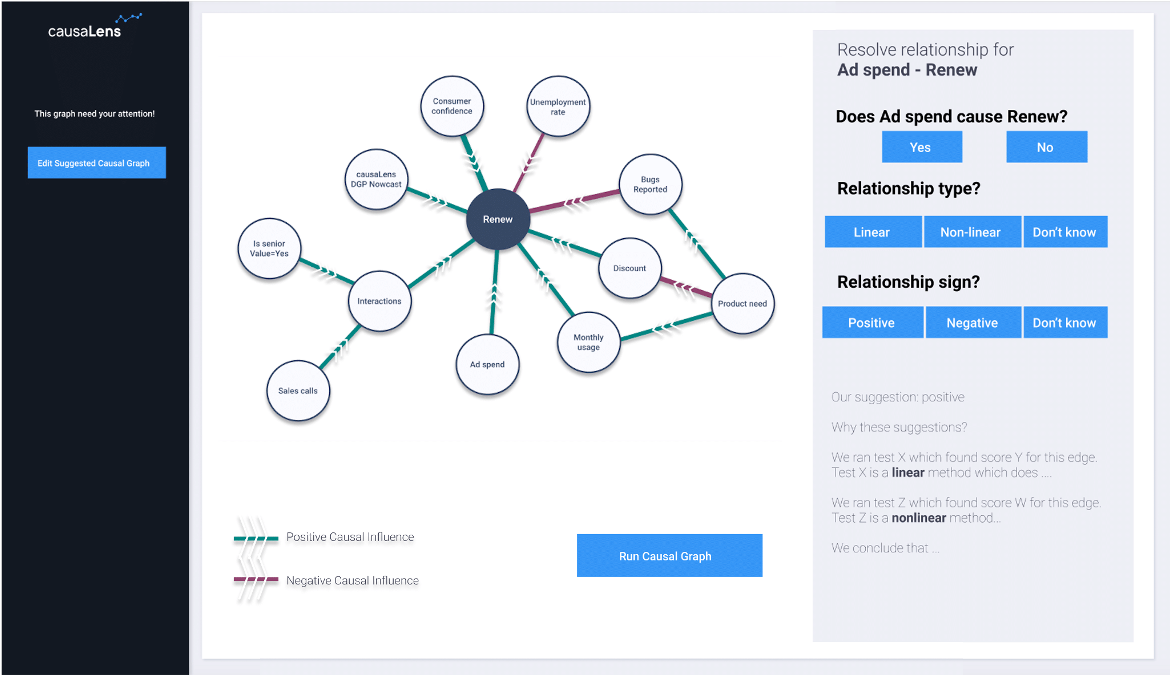

CausaLens é uma empresa de tecnologia que desenvolve soluções baseadas em inteligência artificial (IA) para prever e otimizar resultados em diversas áreas, como finanças, energia e saúde. O objetivo da CausaLens é aplicar a IA causal, uma abordagem que visa identificar relações de causa e efeito nos dados, permitindo previsões mais precisas e interpretações mais profundas.

A abordagem da CausaLens difere de outros métodos de IA tradicionais, que geralmente se baseiam em correlações entre variáveis para fazer previsões. Em vez disso, eles se concentram em entender os mecanismos causais subjacentes aos dados, buscando relações de causa e efeito.

A tecnologia da CausaLens é capaz de analisar grandes quantidades de dados complexos e identificar padrões causais ocultos, permitindo que empresas e organizações tomem decisões mais informadas e precisas. Suas soluções podem ser aplicadas em uma ampla gama de casos de uso, desde a previsão de preços de ativos financeiros até a otimização de redes de energia renovável.

Em resumo, a CausaLens é uma empresa que utiliza a inteligência artificial causal para prever resultados e encontrar insights significativos em diferentes setores, contribuindo para a tomada de decisões mais eficazes.